In [1]:
%matplotlib inline

In [3]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal, scipy.fftpack as ftpk, scipy.integrate as integrate, scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib
# import tensorflow as tf
# import tflearn
from sklearn import linear_model as lm, neural_network as nn
import sklearn.preprocessing as preproc
# import sklearn.model_selection as modselect

original_dir = os.getcwd()

In [4]:
PLOT=True

In [5]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2
SR=400

In [6]:
import pywt
# import pyhht

In [7]:
from imp import reload
import glob

In [10]:
os.chdir('/home/mm/py/kaggle/')
# os.chdir('/home/mike/venvs/ml/ml/py')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics, msig, auxfilter

/home/mm/py/kaggle


In [11]:
reload(plotstuff)
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>

In [12]:
matplotlib.style.use('ggplot')

In [13]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

Functions

In [14]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [15]:
def janky_subdiv(data, subdiv=64, chanVecSize=1024, nChan=16):
    if data.ndim == 3:
        return data[:,::subdiv,:].reshape(-1,chanVecSize*nChan//subdiv)
    elif data.ndim == 2:
        return data[:,::subdiv]
    else:
        raise NotImplementedError("d'oh!")

Data loading section

In [16]:
# basedir = '/run/media/mike/Elements/data/kaggle/melbourne/vectors/'
basedir = '/home/mm/data/vectors/'

data_train = np.load(basedir + 'vec_1478816228.31.npy')
names_train = pd.read_csv(basedir + 'vec_1478816228.31_name.csv')
data_test = np.load(basedir + 'vec_1478825795.45.npy')
names_test = pd.read_csv(basedir + 'vec_1478825795.45_name.csv')
print(data_train.shape, data_test.shape)

(6041, 1024, 16) (1908, 1024, 16)


In [17]:
data_train = np.nan_to_num(data_train)
data_test = np.nan_to_num(data_test)

In [18]:
names_train['label'] = [ int(name[-5]) for name in names_train['path']]
print(names_train.shape, names_train['label'].mean())
names_train.head()

(6041, 3) 0.0743254428075


,Unnamed: 0,path,label
0,0,/media/mike/Elements/data/kaggle/melbourne/tra...,0
1,1,/media/mike/Elements/data/kaggle/melbourne/tra...,0
2,2,/media/mike/Elements/data/kaggle/melbourne/tra...,0
3,3,/media/mike/Elements/data/kaggle/melbourne/tra...,0
4,4,/media/mike/Elements/data/kaggle/melbourne/tra...,0


In [19]:
name_mask = names_train['label'] == 0
name_mask1 = ~name_mask # not necessary, I just goof'd
print(name_mask.shape, name_mask.mean())
name_mask.head()

(6041,) 0.925674557193


0    True
1    True
2    True
3    True
4    True
Name: label, dtype: bool

In [20]:
data_train.shape

(6041, 1024, 16)

In [21]:
X, Y = dataio.reload_with_labels(basedir + 'vec_1478816228.31.npy')
X = np.nan_to_num(X)

In [22]:
X.shape

(6041, 16384)

In [23]:
reload(dataio)
nx = janky_subdiv(X)
nx = nx - np.mean(nx, axis=0)
nx = nx / np.std(nx, axis=0)
folder = dataio.UnbalancedStratifier(nx, Y, nFolds=1)
folder.summary()

Total Samples: 6041
Shapes (256,)
Class 0: 5592
Class 1: 449
Guess  : 0
Prevalence: 8.02932761087%
Zeros bias?  True
Set mean/std: -3.887e-16  1.0
d0  mean/std: 0.01877 0.9961
d1  mean/std: -0.2337 1.019


In [24]:
datasets = [n for n in folder.gimme()]

In [25]:
[(ds[0][0].shape, ds[0][1].shape, ds[1][0].shape, ds[1][1].shape) for ds in datasets]

[((0, 256), (0,), (898, 256), (898,))]

In [26]:
d0 = data_train * name_mask.reshape([6041,1,1])
d1 = data_train* ~name_mask.reshape([6041,1,1])
n0, n1 = np.count_nonzero(d0[:,512,0]), np.count_nonzero(d1[:,512,0])
print(n0, n1)

5536 434


In [27]:
# if PLOT: plt.plot(np.mean(np.mean(data_train, axis=2)==0, axis=1))

'Average (LOGT) power by channel'

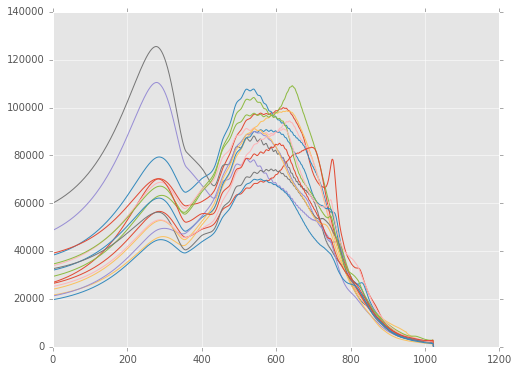

In [28]:
if PLOT: plt.plot(np.mean(data_train, axis=0))
'Average (LOGT) power by channel'

'data set 0 vs 1'

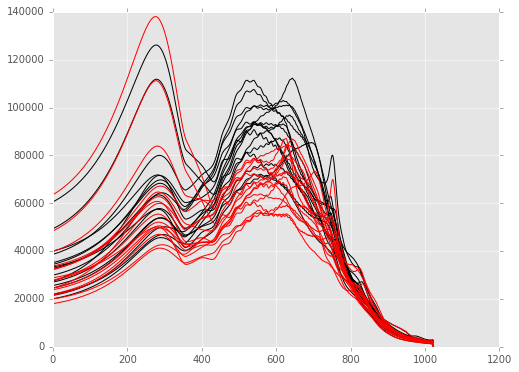

In [29]:
if PLOT: plt.plot(np.sum(d0, axis=0) / n0, c='k')
if PLOT: plt.plot(np.sum(d1, axis=0) / n1, c='r')

'data set 0 vs 1'


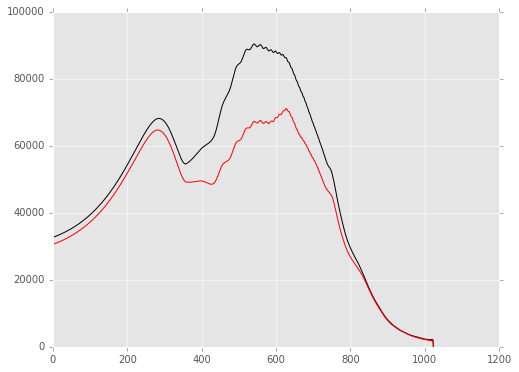

In [30]:
if PLOT: plt.plot(np.mean(np.sum(d0, axis=0) / n0, axis=1), c='k')
if PLOT: plt.plot(np.mean(np.sum(d1, axis=0) / n1, axis=1), c='r')

# NICE!

In [55]:
data_train = X.reshape((6041, 1024, 16)) # note, this is now unsorted

In [31]:
 # avg along electrodes
# simple_dtrain = np.mean(data_train, axis=2)
# simple_dtest = np.mean(data_test, axis=2)

# This is the crazy ass wacky shit that seems to make the classifer work at all in the first place

subdiv = 64
start = 1
simple_dtrain = data_train[:,start::subdiv,:].reshape(-1,1024*16//subdiv)
# simple_dtrain = janky_subdiv(data_train)
print(data_train.shape)
simple_dtest = data_test[:,start::subdiv,:].reshape(-1,1024*16//subdiv)

# Normalize ghetto style - THIS IS VERY SUSPECT
# simple_dtrain -= np.mean(simple_dtrain)
# simple_dtest -= np.mean(simple_dtest)
# simple_dtrain /= np.std(simple_dtrain)
# simple_dtest /= np.std(simple_dtest)
# print(simple_dtrain.shape, simple_dtest.shape)

# BETTER
mean = np.array(np.mean(simple_dtrain)) # deliberately not normalizing feature-wise
std = np.array(np.std(simple_dtrain))
simple_dtrain = simple_dtrain - mean
simple_dtest = simple_dtest - std
simple_dtrain = simple_dtrain / std 
simple_dtest = simple_dtest / std
print(simple_dtrain.shape, simple_dtest.shape)

(6041, 1024, 16)
(6041, 256) (1908, 256)


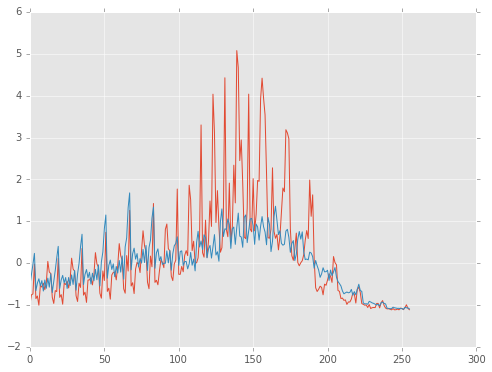

In [33]:
plt.plot(simple_dtrain[3])
plt.plot(np.mean(simple_dtrain, axis=0))

In [34]:
y = np.vstack([name_mask, ~name_mask]).T # label vector will be (N, S), N hot for 'no seiz', S hot for 'seize'
print(y.shape)

(6041, 2)


In [35]:
dtrain_set = np.concatenate([simple_dtrain, y], axis=1)
dtrain_set.shape

(6041, 258)

In [36]:
dframe = pd.DataFrame(dtrain_set)

In [37]:
d0 = dframe[dframe.iloc[:,-1] == 0]
d1 = dframe[dframe.iloc[:,-1] == 1]
print(d0.shape, d1.shape)
nfalse, nhit = d0.shape[0], d1.shape[0]

(5592, 258) (449, 258)


In [38]:
offset = np.random.randint(0, nfalse-nhit-1)
d0b = d0[offset:offset+nhit]
print(d0b.shape)

(449, 258)


In [39]:
d0b_ = d0b.as_matrix()
d1_ = d1.as_matrix()

d1_

array([[-0.91540945, -0.28646171, -0.34454535, ..., -1.12860541,
         0.        ,  1.        ],
       [-1.18480626, -0.24773591, -0.19709424, ..., -1.12927174,
         0.        ,  1.        ],
       [-0.89302867, -0.23613705,  0.7808607 , ..., -1.12881273,
         0.        ,  1.        ],
       ..., 
       [-3.22815867, -1.1554147 , -0.39462072, ..., -1.11202188,
         0.        ,  1.        ],
       [-1.91185346, -0.81795588, -0.15627279, ..., -1.11104334,
         0.        ,  1.        ],
       [-1.00499648, -0.67959517, -1.11558408, ..., -1.11401337,
         0.        ,  1.        ]])

### Shuffle and shit

In [40]:
simple_dtrain.shape

(6041, 256)

In [44]:
subdiv_vec =1
# new_set = np.concatenate([d0b_, d1_], axis=0) # this may go weird
print(new_set.shape)
np.random.shuffle(new_set)
print(np.mean(new_set[:nhit,-1]))
simple_dtrain= new_set[:,:-2]
simple_dtrain_lab = new_set[:,-1]
simple_dtrain = simple_dtrain[:,::subdiv_vec]
print(simple_dtrain.shape)
print(np.mean(simple_dtrain_lab[:nhit]))


NameError: name 'new_set' is not defined

In [45]:
np.mean(new_set[:,-4:], axis=0), np.mean(simple_dtrain[:,-3:], axis=0)

NameError: name 'new_set' is not defined

In [46]:
plt.plot(np.mean(new_set, axis=0))
plt.plot(np.mean(simple_dtrain, axis=0))

NameError: name 'new_set' is not defined

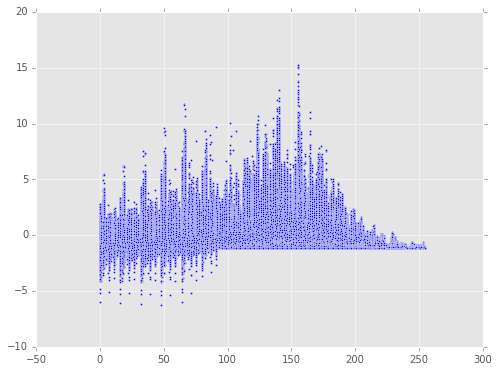

In [47]:
N = len(simple_dtrain)
plt.scatter([np.arange(256),]*N, simple_dtrain[:N], s=5)

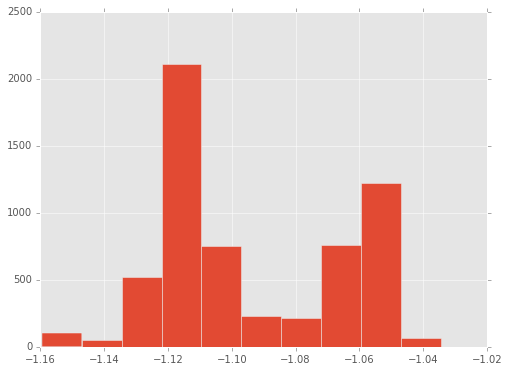

In [48]:
pd.Series(simple_dtrain[:,-1]).hist()

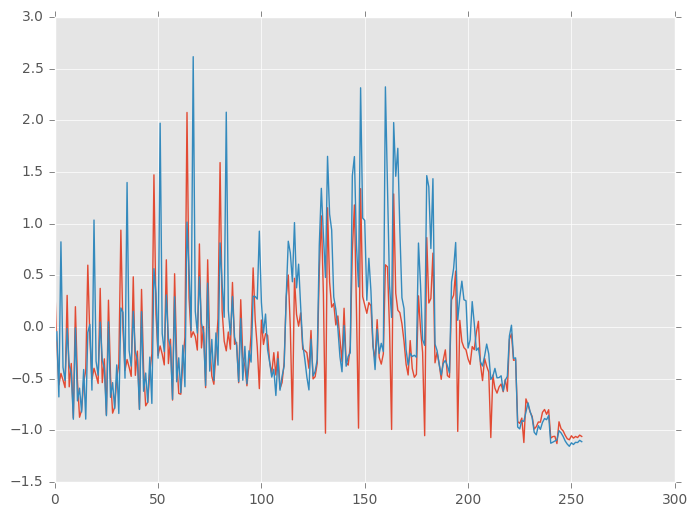

In [217]:
plt.plot(simple_dtrain[0])
plt.plot(simple_dtest[0])

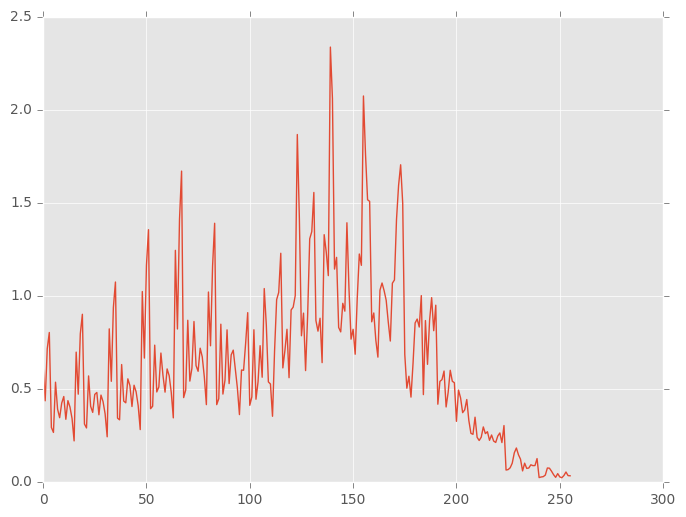

In [218]:
plt.plot(np.std(simple_dtrain, axis=0))

In [49]:
print(simple_dtrain.shape, Y.shape, np.mean(Y), type(simple_dtrain))

(6041, 256) (6041, 1) 0.0743254428075 <type 'numpy.ndarray'>


In [ ]:
# Parition the data into training and evaluation sets
partition = 3*simple_dtrain.shape[0] // 4
# Build 3 layer DNN with 10, 20, 10 units respectively.
nn0 = simple_dtrain.shape[1]
nn1 = 2* nn0
nn2 = nn0

In [279]:
X=simple_dtrain[:partition]
Y=simple_dtrain_lab[:partition]
Xv=simple_dtrain[partition:]
Yv=simple_dtrain_lab[partition:]

In [60]:
folder =  dataio.UnbalancedStratifier(simple_dtrain, Y, nFolds=2)
datasets = [n for n in folder.gimme()]

In [63]:
type(datasets), len(datasets)

(list, 2)

In [80]:
(xt, yt), (xv, yv) = datasets[0]
(xt1, yt1), (xv1, yv1) = datasets[1]

In [69]:
print(yt.shape, np.mean(yt), np.mean(yv))
print(xt.shape, xv.shape, yt.shape, yv.shape)

(450,) 0.5 0.5
(450, 256) (448, 256) (450,) (448,)


In [33]:
assert 0 # break point

AssertionError: 

In [ ]:
# Classification
# def do_a_graph():
# with tf.Graph().as_default(): # re-initializing the cells fucks shit up yo
tf.reset_default_graph()
tflearn.init_graph(num_cores=8, gpu_memory_fraction=0.5) # DO ONLY ONCE!

net = tflearn.input_data(shape=[None, nn0])
net = tflearn.fully_connected(net, 10)
# net = tflearn.dropout(net, 0.5)
net = tflearn.fully_connected(net, 1, activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')

model = tflearn.DNN(net)
model.fit(X, Y.reshape(-1,1),n_epoch=1)
# model.save('model')
    #     return model

In [ ]:
# with tf.Graph().as_default(): 
#     model.load('model')
ev = model.evaluate(Xv, Yv.reshape(-1,1))
print(ev)

In [ ]:
ev

In [ ]:
pr = model.predict(simple_dtest)

In [ ]:
pr_ = np.array(pr)

In [ ]:
np.mean(pr_[:,0])

In [ ]:
pr_.shape

In [ ]:
guess = pr_[:,1] > .5
guess

In [ ]:
names_test['guess'] = pd.Series(pr_[1,:])

In [ ]:
names_test['']

In [ ]:
perc = lm.Perceptron()

In [ ]:
perc.fit(X, Y)

In [ ]:
perc.score(Xv, Yv)

In [ ]:
pr = perc.predict(simple_dtest[:,::16])
print(pr.mean())

In [ ]:
names_test['guess'] = pd.Series(pr)

In [ ]:
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [ ]:
names_test.to_csv('guess11_10_perc.csv')

In [ ]:
ls

# SKLearn MLP

In [181]:
X256 = janky_subdiv(X)

In [73]:
mlp = nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1)
print(xt.shape, yt.shape)

(450, 256) (450,)


In [74]:
mlp.fit(xt, yt)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(256, 32, 256, 32), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=1)

In [85]:
mlp.score(xt, yt), mlp.score(xv, yv), 

(0.92000000000000004, 0.5089285714285714)

In [81]:
mlp.score(xt1, yt1)

0.51111111111111107

In [79]:
print(np.mean(yt, axis=0))

0.5


In [82]:
backcheck = mlp.predict(xt)
print(np.mean(backcheck, axis=0))

0.491111111111


In [84]:
np.mean(backcheck == yt)

0.92000000000000004

In [286]:
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.py'>

In [287]:
fold_mlp = dataio.UnbalancedStratifier(X, Y,mandateZerosExcess=0)
fold_mlp.summary()

Total Samples: 673
Shapes (256,)
Class 0: 329
Class 1: 344
Guess  : 0
Prevalence: 104.559270517%
Zeros bias?  False
Set mean/std: -0.07053 1.038
d0  mean/std: 0.04048 1.197
d1  mean/std: -0.1767 0.8456


In [226]:
print(np.mean(mlp.predict(Xv), axis=0))
print(np.mean(Yv, axis=0))

0.524444444444
0.533333333333


In [224]:
pr = mlp.predict(simple_dtest)
print(pr.mean())

0.75


In [201]:
names_test['Class'] = pd.Series(pr)
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [202]:
guessfile = names_test[['File', 'Class']]
guessfile.to_csv('guess11_10_mlp_256.csv', index=False)

In [40]:
mlp_z = nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1)

In [48]:
robuster = preproc.RobustScaler()

In [49]:
robuster.fit(X, Y)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [52]:
X_r = robuster.fit_transform(X)
Xv_r = robuster.fit_transform(Xv)

In [53]:
mlp.fit(X_r, Y)
mlp.score(Xv_r, Yv)

0.88444444444444448

In [56]:
pred = mlp.predict(Xv)
np.mean(pred, axis=0), np.mean(Yv, axis=0)

(0.34666666666666668, 0.48888888888888887)

# K-Fold MLP

In [254]:
models = [nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1) for i in range(10)]

In [255]:
K=2
(xt, yt), (xv, yv) = datasets[0]
print(xt.shape, yt.shape, xv.shape, yv.shape)

(450, 256) (450,) (448, 256) (448,)


In [256]:
for i in range(K):
    (xt, yt), (xv, yv) = datasets[i]
    models[i].fit(xt, yt)
    print(models[i].score(xv, yv), np.mean(models[i].predict(xv), axis=0))

0.511160714286 0.613839285714
0.502232142857 0.399553571429


In [257]:
for i in range(K):
    print(np.mean(models[i].predict(X), axis=0))

ValueError: shapes (6041,16384) and (256,256) not aligned: 16384 (dim 1) != 256 (dim 0)

In [117]:
for i in range(10):
    (xt, yt), (xv, yv) = datasets[i]
    print(np.mean(yt, axis=0), np.mean(yv, axis=0))

0.5 0.5
0.5 0.5
0.5 0.5
0.5 0.5
0.5 0.5
0.5 0.5
0.5 0.5
0.5 0.5
0.5 0.5
0.5 0.5


# Sparse PCA

In [177]:
from sklearn import decomposition

In [206]:
foo = decomposition.SparsePCA(16)

In [207]:
foo.fit(X, Y)

SparsePCA(U_init=None, V_init=None, alpha=1, max_iter=1000, method='lars',
     n_components=16, n_jobs=1, random_state=None, ridge_alpha=0.01,
     tol=1e-08, verbose=False)

In [208]:
foo.components_

array([[ 11.64966909,   4.39139989,  11.08444758, ...,  25.82489159,
         26.19093528,  26.62494138],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,   0.38085367,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  -4.1738491 ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [209]:
foo.components_.shape

(16, 256)

In [212]:
xprime = foo.transform(X)

In [213]:
xprime.shape

(673, 16)

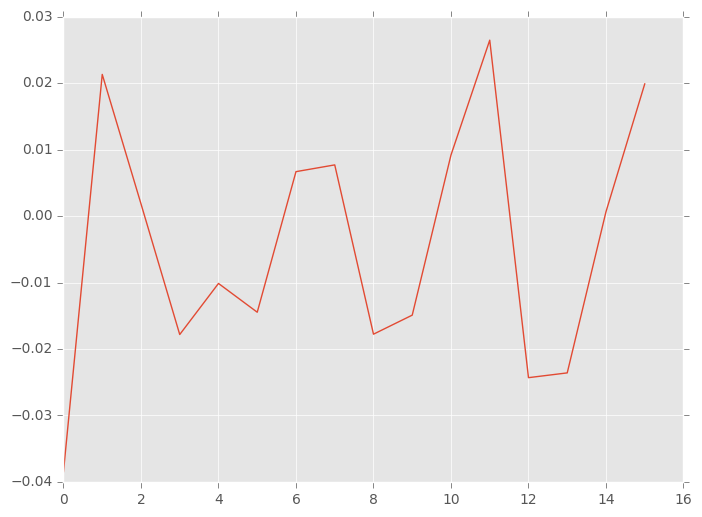

In [214]:
plt.plot(np.mean(xprime, axis=0))

In [229]:
mlp = nn.MLPClassifier(hidden_layer_sizes=(512,16,4), activation='relu', warm_start=1)

In [240]:
mlp.fit(xprime, Y)
print(mlp.score(foo.transform(Xv), Yv))
pr = mlp.predict(foo.transform(simple_dtest))
print(pr.mean())

0.857777777778
0.68501048218


In [241]:
names_test['Class'] = pd.Series(pr)
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [242]:
guessfile = names_test[['File', 'Class']]
guessfile.to_csv('guess11_10_mlp_pca16.csv', index=False)